In [4]:
%matplotlib inline 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from assemble import DataStream, DataDescribe, Category, DataCleaner
import warnings
import json
import pickle
from imp import reload

from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RandomizedLasso
from sklearn.linear_model import HuberRegressor
#from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_rand
import operator

#from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

# Input

In [2]:
X_train, X_test, y  = DataStream.read_for_learn("data.json", "2-20Submit-Polynomal")

# Optional: Input Verification

(1456, 114)
(1459, 114)
(1456,)


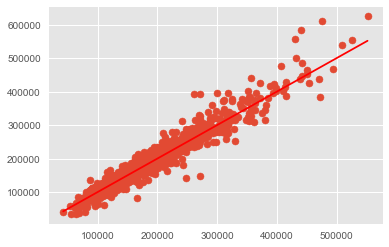

In [6]:
model = Lasso(alpha = 2e-4, max_iter =  50000).fit(X_train, y)
p_pred = np.expm1(model.predict(X_train))
plt.scatter(p_pred, np.expm1(y))
plt.plot([min(p_pred),max(p_pred)], [min(p_pred),max(p_pred)], c="red")

train,test= DataStream.load_data("data.json")
p = np.expm1(model.predict(X_test))
solution = pd.DataFrame({"id":test.Id, "SalePrice":p}, columns=['id', 'SalePrice'])
solution.to_csv("../data/submission/tmp_test.csv", index = False)

print(X_train.shape)
print(X_test.shape)
print(y.shape)

# Randomlized Lasso

## * parameter tuning

In [17]:
# construct Lasso 
model = Lasso()
#random seed
np.random.seed(1)
# use random parameter
par_dict={'alpha': sp_rand()}
# # of searching
N_search = 10000
# contruct tuner
tuner = RandomizedSearchCV(estimator=model, 
                             param_distributions=par_dict, 
                             n_iter=N_search)
# tune parameter (alpha)
tuner.fit(X_train,y)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
          fit_params={}, iid=True, n_iter=10000, n_jobs=1,
          param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022B33FD1EB8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [18]:
#alpha_Lasso = tuner.best_estimator_.alpha
alpha_Lasso = 0.000248109691441
print(alpha_Lasso)

0.000248109691441


## * fit randomlized lasso

In [19]:
# max iteration 
max_it = 50000
# number of re-sampling
n_resample = 500
# constructu randomlized Lasso
rlasso = RandomizedLasso(alpha=alpha_Lasso, 
                         max_iter=max_it,
                         random_state=1,
                         n_resampling=n_resample)
# fit randomlized Lasso
rlasso.fit(X_train, y)

RandomizedLasso(alpha=0.000248109691441, eps=2.2204460492503131e-16,
        fit_intercept=True, max_iter=50000, memory=Memory(cachedir=None),
        n_jobs=1, n_resampling=500, normalize=True,
        pre_dispatch='3*n_jobs', precompute='auto', random_state=1,
        sample_fraction=0.75, scaling=0.5, selection_threshold=0.25,
        verbose=False)

In [20]:
# get transformed X
X_transform = rlasso.transform(X_train)
X_test_transform = rlasso.transform(X_test)

In [8]:
########################
# tune parameter again #
########################

# construct Lasso 
model = Lasso()
#random seed
np.random.seed(1)
# use random parameter
par_dict={'alpha': sp_rand()}
# # of searching
N_search = 10000
# contruct tuner
tuner = RandomizedSearchCV(estimator=model, 
                             param_distributions=par_dict, 
                             n_iter=N_search)
tuner.fit(X_transform,y)
alpha_Lasso = tuner.best_estimator_.alpha
print(alpha_Lasso)

0.000141330208427


In [9]:
# construct lasso
mlasso =  Lasso(alpha=alpha_Lasso,
               max_iter = max_it,
               random_state=1)
# fit to lasso
mlasso.fit(X_transform,y)
# predict
y_pred_mlasso=mlasso.predict(X_test_transform)
# get R^2 score
#r2_score_lasso = r2_score(y_test, y_pred_mlasso)
score_mlasso = cross_val_score(mlasso, X_transform, y, cv=5,scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (score_mlasso.mean(), 
                                       score_mlasso.std() * 2))

Accuracy: 0.92 (+/- 0.01)


In [25]:
# return the mask
mask_rlasso = rlasso.get_support()
print(mask_rlasso)

[False False  True  True False  True False False False False  True False
  True False  True  True False  True  True False  True  True  True False
  True False  True False False False False  True False  True False  True
 False  True  True False  True False False  True False  True  True False
  True False False  True False  True False False False False False False
 False False False False False  True  True  True False False  True False
  True False False  True  True  True  True False  True False False  True
 False False  True  True  True  True False False False  True False  True
  True  True  True  True  True  True  True  True False  True  True False
 False False False False False  True]


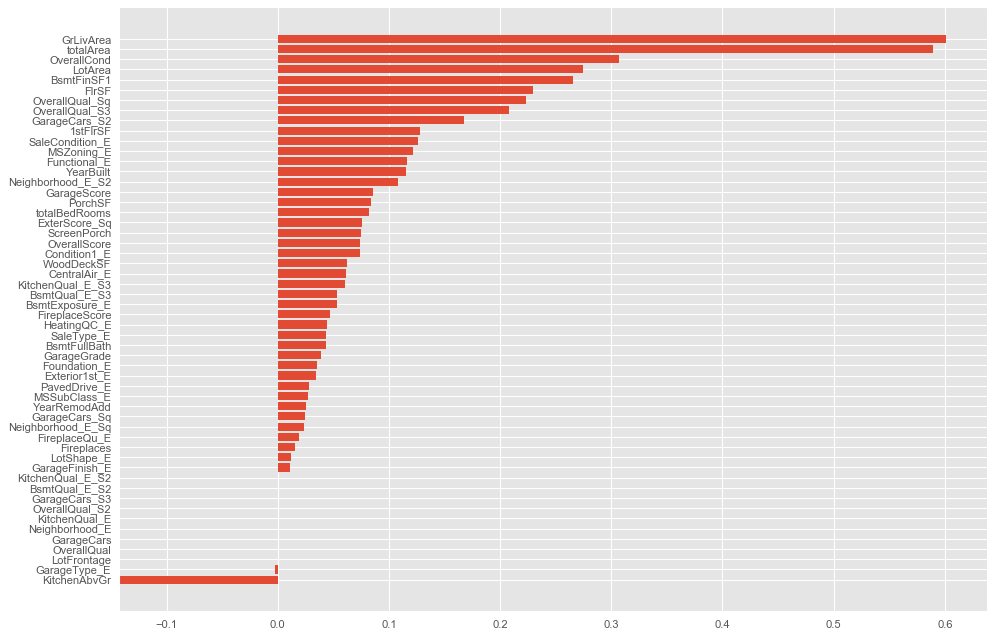

In [11]:
# return masked coffecient
coef_mlasso = mlasso.coef_

# plot coffecient
name_mlasso = X_train.columns[mask_rlasso]
coef_dict_mlasso = dict(zip(name_mlasso,coef_mlasso))
coef_dict_mlasso = sorted(coef_dict_mlasso.items(), key=operator.itemgetter(1))
coef_dict_mlasso = dict((x, y) for x, y in coef_dict_mlasso)
plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
import warnings
plt.barh(range(len(coef_dict_mlasso)), coef_dict_mlasso.values(), align='center')
plt.yticks(range(len(coef_dict_mlasso)), coef_dict_mlasso.keys())
warnings.filterwarnings('ignore')

# * make a submission

In [36]:
# save to file to make a submission
train,test= DataStream.load_data("data.json")
p = np.expm1(mlasso.predict(X_test_transform))
solution = pd.DataFrame({"id":test.Id, "SalePrice":p}, columns=['id', 'SalePrice'])
solution.to_csv("../data/submission/test-3-13-Lasso.csv", index = False)

# Huber Regression with Tranformed Features in Lasso

## * tune eplison

In [39]:
# construct Huber 
model =  HuberRegressor()
#random seed
np.random.seed(1)
# use random parameter
par_dict={'epsilon': sp_rand()}
# use parameter pool
#epsilon_values = {'epsilon':[1.35, 1.5, 1.75, 1.9]}
epsilon_values = {'epsilon':np.arange(1.35,2.0,0.01)}
print(epsilon_values)
# # of searching
N_search = 10000
# contruct tuner
#tuner = RandomizedSearchCV(estimator=model, 
#                             param_distributions=par_dict, 
#                             n_iter=N_search)
tuner = GridSearchCV(estimator=model, 
                     param_grid=epsilon_values)
# tune parameter (alpha)
tuner.fit(X_transform,y)

{'epsilon': array([ 1.35,  1.36,  1.37,  1.38,  1.39,  1.4 ,  1.41,  1.42,  1.43,
        1.44,  1.45,  1.46,  1.47,  1.48,  1.49,  1.5 ,  1.51,  1.52,
        1.53,  1.54,  1.55,  1.56,  1.57,  1.58,  1.59,  1.6 ,  1.61,
        1.62,  1.63,  1.64,  1.65,  1.66,  1.67,  1.68,  1.69,  1.7 ,
        1.71,  1.72,  1.73,  1.74,  1.75,  1.76,  1.77,  1.78,  1.79,
        1.8 ,  1.81,  1.82,  1.83,  1.84,  1.85,  1.86,  1.87,  1.88,
        1.89,  1.9 ,  1.91,  1.92,  1.93,  1.94,  1.95,  1.96,  1.97,
        1.98,  1.99])}


GridSearchCV(cv=None, error_score='raise',
       estimator=HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'epsilon': array([ 1.35,  1.36, ...,  1.98,  1.99])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [41]:
epsilon_huber = tuner.best_estimator_.epsilon
# epsilon_huber = 1.78
print(epsilon_huber)

1.78


## * fit Huber regression

In [42]:
mhuber = HuberRegressor(fit_intercept=True, max_iter=10000,
                           epsilon=epsilon_huber)
mhuber.fit(X_transform, y)

HuberRegressor(alpha=0.0001, epsilon=1.7800000000000005, fit_intercept=True,
        max_iter=10000, tol=1e-05, warm_start=False)

In [43]:
# predict
y_pred_mhuber=mhuber.predict(X_test_transform)

# get R^2 score
#r2_score_lasso = r2_score(y_test, y_pred_mlasso)
score_mhuber = cross_val_score(mhuber, X_transform, y, cv=5,scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (score_mhuber.mean(), 
                                       score_mhuber.std() * 2))

Accuracy: 0.92 (+/- 0.01)


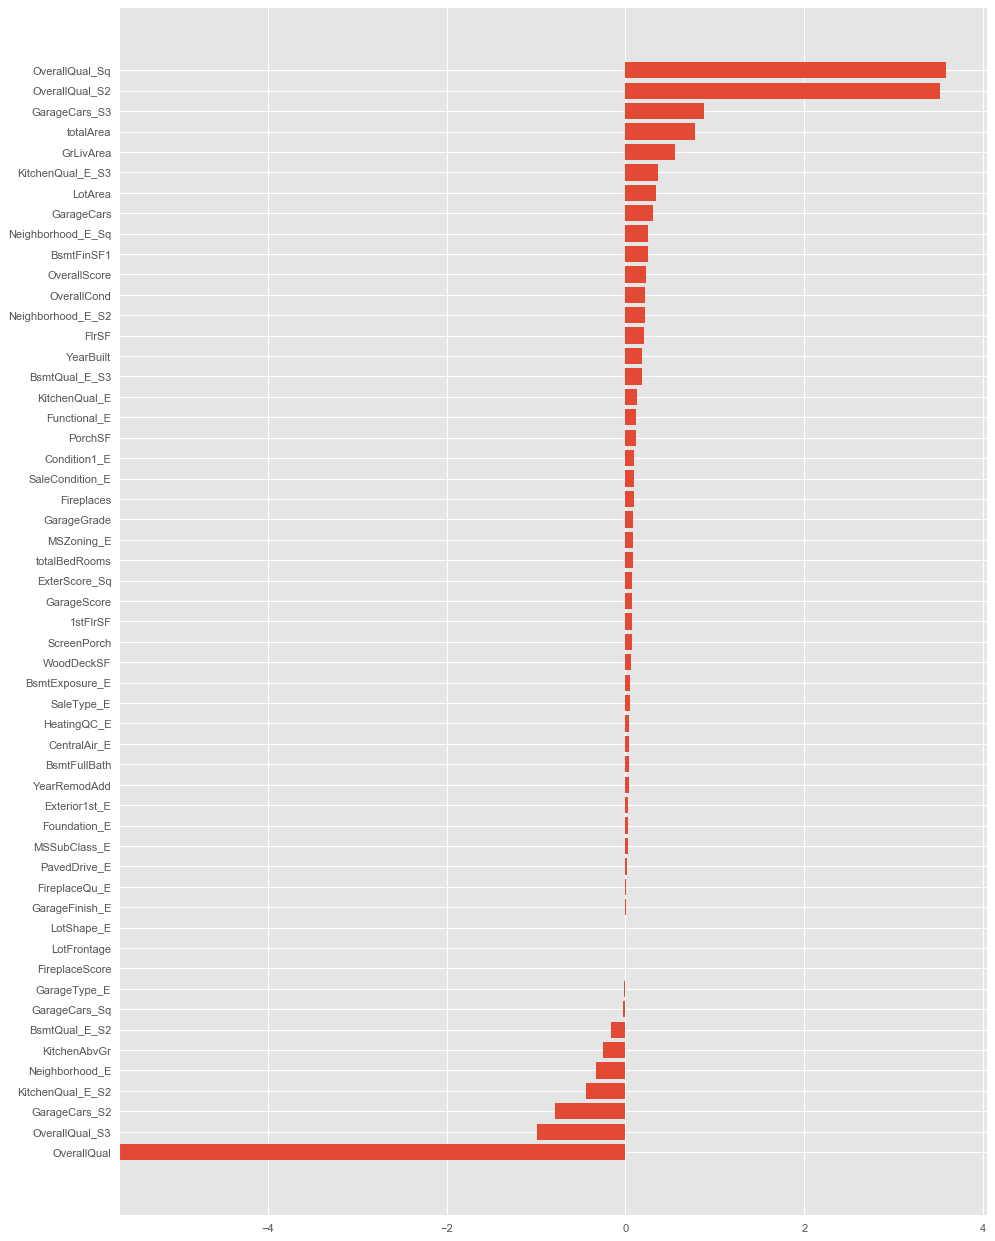

In [45]:
# return masked coffecient
coef_mhuber = mhuber.coef_

# plot coffecient
name_m = name_mlasso
coef_dict_mhuber = dict(zip(name_m,coef_mhuber))
coef_dict_mhuber = sorted(coef_dict_mhuber.items(), key=operator.itemgetter(1))
coef_dict_mhuber = dict((x, y) for x, y in coef_dict_mhuber)
#print(coef_dict_mhuber)
plt.figure(num=None, figsize=(14, 20), dpi=80, facecolor='w', edgecolor='k')
import warnings
plt.barh(range(len(coef_dict_mhuber)), coef_dict_mhuber.values(), align='center')
plt.yticks(range(len(coef_dict_mhuber)), coef_dict_mhuber.keys())
warnings.filterwarnings('ignore')

# * make a submission

In [47]:
# save to file to make a submission
train,test= DataStream.load_data("data.json")
p = np.expm1(mhuber.predict(X_test_transform))
solution = pd.DataFrame({"id":test.Id, "SalePrice":p}, columns=['id', 'SalePrice'])
solution.to_csv("../data/submission/test-3-15-huber_selected.csv", index = False)

# Huber Regression

## * tune eplison

In [26]:
# construct Huber 
model =  HuberRegressor()
#random seed
np.random.seed(1)
# use random parameter
par_dict={'epsilon': sp_rand()}
# use parameter pool
#epsilon_values = {'epsilon':[1.35, 1.5, 1.75, 1.9]}
epsilon_values = {'epsilon':np.arange(1.35,2.0,0.01)}
print(epsilon_values)
# # of searching
N_search = 10000
# contruct tuner
#tuner = RandomizedSearchCV(estimator=model, 
#                             param_distributions=par_dict, 
#                             n_iter=N_search)
tuner = GridSearchCV(estimator=model, 
                     param_grid=epsilon_values)
# tune parameter (alpha)
tuner.fit(X_train,y)

{'epsilon': array([ 1.35,  1.36,  1.37,  1.38,  1.39,  1.4 ,  1.41,  1.42,  1.43,
        1.44,  1.45,  1.46,  1.47,  1.48,  1.49,  1.5 ,  1.51,  1.52,
        1.53,  1.54,  1.55,  1.56,  1.57,  1.58,  1.59,  1.6 ,  1.61,
        1.62,  1.63,  1.64,  1.65,  1.66,  1.67,  1.68,  1.69,  1.7 ,
        1.71,  1.72,  1.73,  1.74,  1.75,  1.76,  1.77,  1.78,  1.79,
        1.8 ,  1.81,  1.82,  1.83,  1.84,  1.85,  1.86,  1.87,  1.88,
        1.89,  1.9 ,  1.91,  1.92,  1.93,  1.94,  1.95,  1.96,  1.97,
        1.98,  1.99])}


GridSearchCV(cv=None, error_score='raise',
       estimator=HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'epsilon': array([ 1.35,  1.36, ...,  1.98,  1.99])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [28]:
epsilon_huber = tuner.best_estimator_.epsilon
# epsilon_huber = 1.44
print(epsilon_huber)

1.44


## * fit Huber regression

In [31]:
mhuber = HuberRegressor(fit_intercept=True, max_iter=10000,
                           epsilon=epsilon_huber)
mhuber.fit(X_train, y)

HuberRegressor(alpha=0.0001, epsilon=1.4400000000000002, fit_intercept=True,
        max_iter=10000, tol=1e-05, warm_start=False)

In [35]:
# predict
y_pred_mhuber=mhuber.predict(X_test)

# get R^2 score
#r2_score_lasso = r2_score(y_test, y_pred_mlasso)
score_mhuber = cross_val_score(mhuber, X_train, y, cv=5,scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (score_mhuber.mean(), 
                                       score_mhuber.std() * 2))

Accuracy: 0.92 (+/- 0.02)


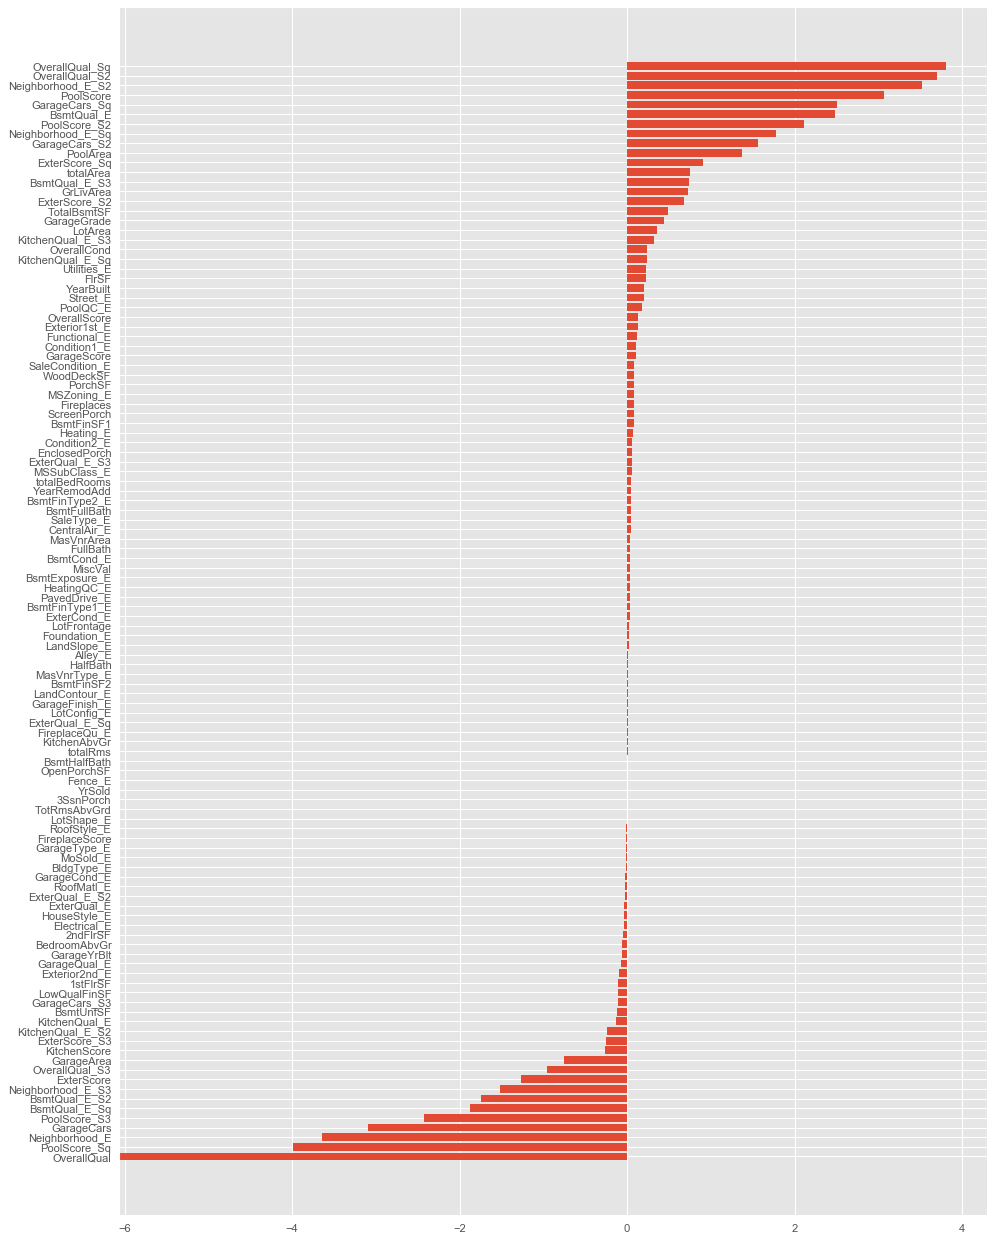

In [38]:
# return masked coffecient
coef_mhuber = mhuber.coef_

# plot coffecient
name_m = X_train.columns
coef_dict_mhuber = dict(zip(name_m,coef_mhuber))
coef_dict_mhuber = sorted(coef_dict_mhuber.items(), key=operator.itemgetter(1))
coef_dict_mhuber = dict((x, y) for x, y in coef_dict_mhuber)
#print(coef_dict_mhuber)
plt.figure(num=None, figsize=(14, 20), dpi=80, facecolor='w', edgecolor='k')
import warnings
plt.barh(range(len(coef_dict_mhuber)), coef_dict_mhuber.values(), align='center')
plt.yticks(range(len(coef_dict_mhuber)), coef_dict_mhuber.keys())
warnings.filterwarnings('ignore')

# * make a submission

In [36]:
# save to file to make a submission
train,test= DataStream.load_data("data.json")
p = np.expm1(mhuber.predict(X_test))
solution = pd.DataFrame({"id":test.Id, "SalePrice":p}, columns=['id', 'SalePrice'])
solution.to_csv("../data/submission/test-3-13-huber.csv", index = False)

# Ridge CV with selected features

## * fit ridge

In [23]:
# use parameter pool
alpha_values = np.arange(0.3,1.8,0.005)
print(alpha_values)

# construct Ridge
mridgecv =  RidgeCV(alphas=alpha_values)

# fit
mridgecv.fit(X_transform,y)
print(mridgecv.alpha_)

[ 0.3    0.305  0.31   0.315  0.32   0.325  0.33   0.335  0.34   0.345
  0.35   0.355  0.36   0.365  0.37   0.375  0.38   0.385  0.39   0.395  0.4
  0.405  0.41   0.415  0.42   0.425  0.43   0.435  0.44   0.445  0.45
  0.455  0.46   0.465  0.47   0.475  0.48   0.485  0.49   0.495  0.5    0.505
  0.51   0.515  0.52   0.525  0.53   0.535  0.54   0.545  0.55   0.555
  0.56   0.565  0.57   0.575  0.58   0.585  0.59   0.595  0.6    0.605
  0.61   0.615  0.62   0.625  0.63   0.635  0.64   0.645  0.65   0.655
  0.66   0.665  0.67   0.675  0.68   0.685  0.69   0.695  0.7    0.705
  0.71   0.715  0.72   0.725  0.73   0.735  0.74   0.745  0.75   0.755
  0.76   0.765  0.77   0.775  0.78   0.785  0.79   0.795  0.8    0.805
  0.81   0.815  0.82   0.825  0.83   0.835  0.84   0.845  0.85   0.855
  0.86   0.865  0.87   0.875  0.88   0.885  0.89   0.895  0.9    0.905
  0.91   0.915  0.92   0.925  0.93   0.935  0.94   0.945  0.95   0.955
  0.96   0.965  0.97   0.975  0.98   0.985  0.99   0.995  1.     1

In [24]:
# get R^2 score
#r2_score_lasso = r2_score(y_test, y_pred_mlasso)
score_mridgecv = cross_val_score(mridgecv, X_transform, y, cv=5,scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (score_mridgecv.mean(), 
                                       score_mridgecv.std() * 2))

Accuracy: 0.92 (+/- 0.01)


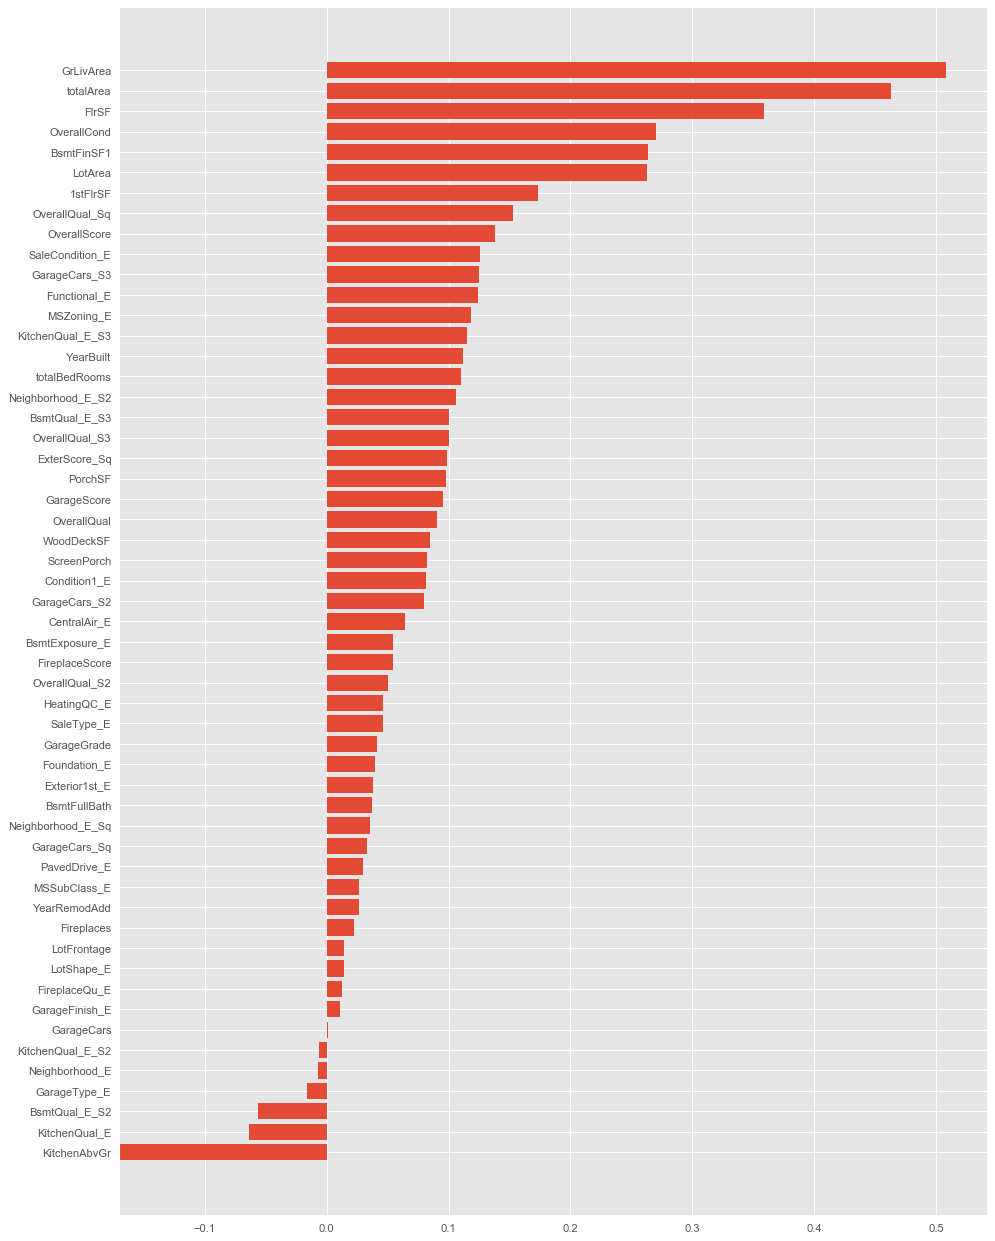

In [26]:
# prepare coef_
coef_mridgecv = mridgecv.coef_

# plot coffecient
name_m = X_train.columns[mask_rlasso]
coef_dict_mridgecv = dict(zip(name_m,coef_mridgecv))
coef_dict_mridgecv = sorted(coef_dict_mridgecv.items(), key=operator.itemgetter(1))
coef_dict_mridgecv = dict((x, y) for x, y in coef_dict_mridgecv)
#print(coef_dict_mhuber)
plt.figure(num=None, figsize=(14, 20), dpi=80, facecolor='w', edgecolor='k')
import warnings
plt.barh(range(len(coef_dict_mridgecv)), coef_dict_mridgecv.values(), align='center')
plt.yticks(range(len(coef_dict_mridgecv)), coef_dict_mridgecv.keys())
warnings.filterwarnings('ignore')

# * make a submission

In [28]:
# save to file to make a submission
train,test= DataStream.load_data("data.json")
p = np.expm1(mridgecv.predict(X_test_transform))
solution = pd.DataFrame({"id":test.Id, "SalePrice":p}, columns=['id', 'SalePrice'])
solution.to_csv("../data/submission/test-3-15-ridgecv_selectedfeature.csv", index = False)

# Ridge CV

## * fit ridge

In [10]:
# use parameter pool
alpha_values = np.arange(1.0,2.0,0.01)
print(alpha_values)

# construct Ridge
mridgecv =  RidgeCV(alphas=alpha_values)

# fit
mridgecv.fit(X_train,y)
print(mridgecv.alpha_)

[ 1.    1.01  1.02  1.03  1.04  1.05  1.06  1.07  1.08  1.09  1.1   1.11
  1.12  1.13  1.14  1.15  1.16  1.17  1.18  1.19  1.2   1.21  1.22  1.23
  1.24  1.25  1.26  1.27  1.28  1.29  1.3   1.31  1.32  1.33  1.34  1.35
  1.36  1.37  1.38  1.39  1.4   1.41  1.42  1.43  1.44  1.45  1.46  1.47
  1.48  1.49  1.5   1.51  1.52  1.53  1.54  1.55  1.56  1.57  1.58  1.59
  1.6   1.61  1.62  1.63  1.64  1.65  1.66  1.67  1.68  1.69  1.7   1.71
  1.72  1.73  1.74  1.75  1.76  1.77  1.78  1.79  1.8   1.81  1.82  1.83
  1.84  1.85  1.86  1.87  1.88  1.89  1.9   1.91  1.92  1.93  1.94  1.95
  1.96  1.97  1.98  1.99]
1.39


In [11]:
# get R^2 score
#r2_score_lasso = r2_score(y_test, y_pred_mlasso)
score_mridgecv = cross_val_score(mridgecv, X_train, y, cv=5,scoring='r2')
print("Accuracy: %0.2f (+/- %0.2f)" % (score_mridgecv.mean(), 
                                       score_mridgecv.std() * 2))

Accuracy: 0.92 (+/- 0.01)


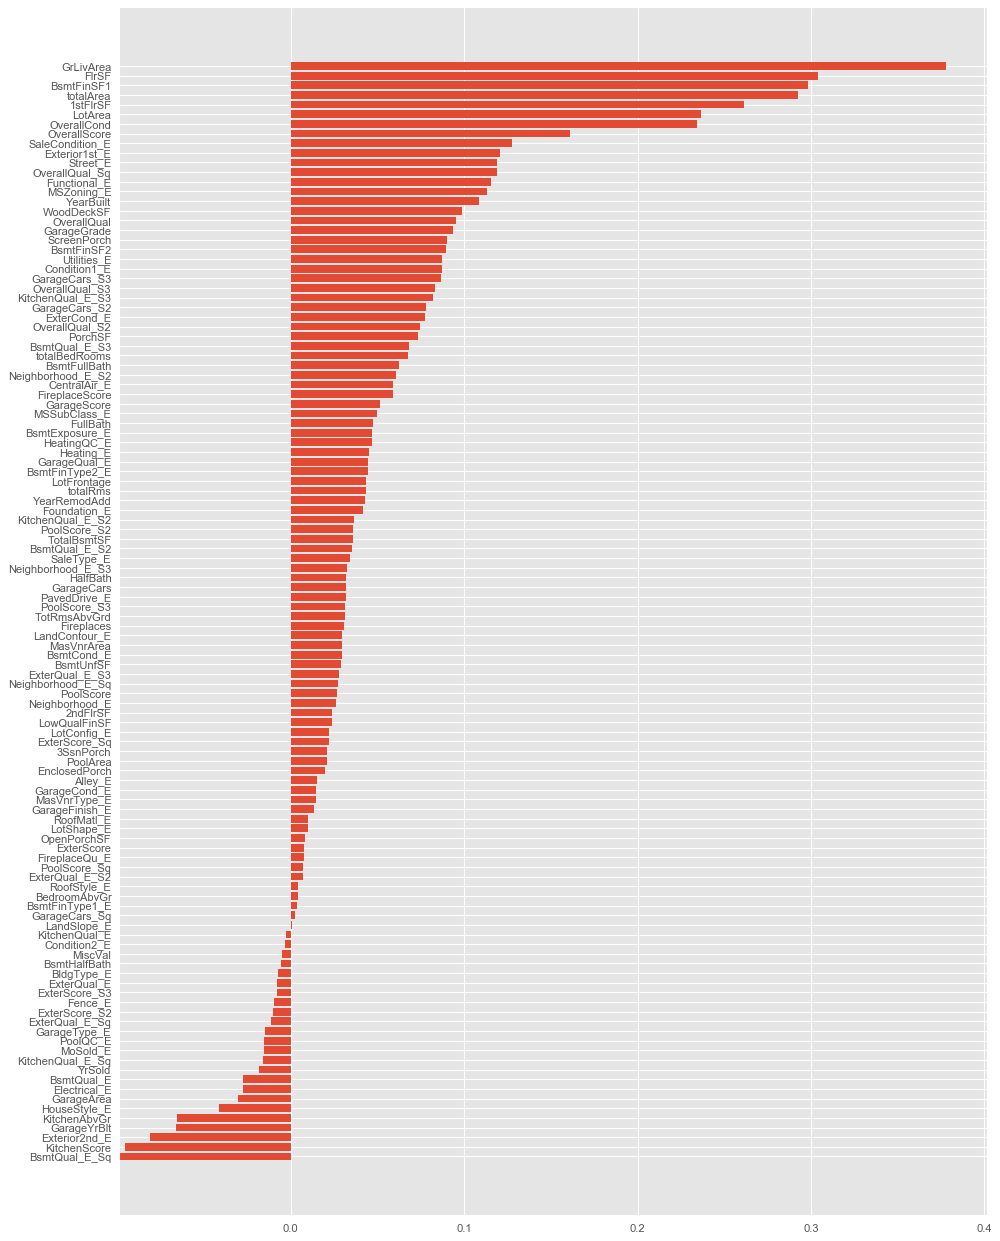

In [12]:
# prepare coef_
coef_mridgecv = mridgecv.coef_

# plot coffecient
name_m = X_train.columns
coef_dict_mridgecv = dict(zip(name_m,coef_mridgecv))
coef_dict_mridgecv = sorted(coef_dict_mridgecv.items(), key=operator.itemgetter(1))
coef_dict_mridgecv = dict((x, y) for x, y in coef_dict_mridgecv)
#print(coef_dict_mhuber)
plt.figure(num=None, figsize=(14, 20), dpi=80, facecolor='w', edgecolor='k')
import warnings
plt.barh(range(len(coef_dict_mridgecv)), coef_dict_mridgecv.values(), align='center')
plt.yticks(range(len(coef_dict_mridgecv)), coef_dict_mridgecv.keys())
warnings.filterwarnings('ignore')

In [27]:
# save to file to make a submission
train,test= DataStream.load_data("data.json")
p = np.expm1(mridgecv.predict(X_test))
solution = pd.DataFrame({"id":test.Id, "SalePrice":p}, columns=['id', 'SalePrice'])
solution.to_csv("../data/submission/test-3-15-ridgecv.csv", index = False)

# [In progress] Automatic feature selection module

In [12]:
import feature_select
reload(feature_select)

model = Lasso()
#par_grid = dict(alpha=np.array([1,0.1,0.01,0.001,0.0001,0]))
# prepare a uniform distribution to sample for the alpha parameter
#par_grid = {'alpha': sp_rand()} 
feature_filter = feature_select.Feature_Filter(model,X_train,y)
#para_filter.tune_par_grid(par_grid)
#para_filter.tune_par_rand(par_dict=par_grid,N_search=1000)
#para_filter.rand_lasso()
rankdict = feature_filter.auto_select(N_searchCV=10000)


In [13]:
print(feature_filter.SearchCV.best_estimator_.alpha)
#print(rankdict)
#print(rankdict['Rn_La'][0][1])

0.000248109691441


alpha = RandomCV(10000)->0.000248109691441

In [36]:
rank_dict0=dict((x, y) for x, y in rankdict['Rn_La'])
weak_feature = []
strong_feature = []
for k,v in rank_dict0.items():
    if v < 0.1:
        weak_feature.append(k)        
    else:
        strong_feature.append(k)
print(weak_feature)
print(strong_feature)

['ExterCond_E', 'Electrical_E', 'GarageArea', 'FullBath', 'BsmtQual_E_Sq', 'ExterScore_S3', 'ExterQual_E', 'TotRmsAbvGrd', 'BsmtFinSF2', 'Exterior2nd_E', 'ExterQual_E_S2', '2ndFlrSF', 'YrSold', 'PoolScore_S2', 'RoofStyle_E', 'LandSlope_E', 'PoolScore', 'BsmtFinType1_E', 'PoolArea', 'BsmtFinType2_E', 'LowQualFinSF', 'KitchenScore', 'RoofMatl_E', 'PoolScore_S3', '3SsnPorch', 'BedroomAbvGr', 'Fence_E', 'MoSold_E', 'Utilities_E', 'BsmtHalfBath', 'MiscVal', 'Alley_E', 'EnclosedPorch', 'Condition2_E', 'HouseStyle_E', 'PoolQC_E', 'PoolScore_Sq']
['SaleCondition_E', 'LotArea', 'CentralAir_E', 'MSZoning_E', 'BsmtFinSF1', 'OverallScore', 'totalArea', 'MSSubClass_E', 'totalBedRooms', 'GrLivArea', '1stFlrSF', 'BsmtExposure_E', 'Functional_E', 'FireplaceScore', 'FlrSF', 'YearRemodAdd', 'HeatingQC_E', 'Neighborhood_E', 'YearBuilt', 'Foundation_E', 'GarageGrade', 'Condition1_E', 'GarageFinish_E', 'BsmtQual_E_S3', 'GarageScore', 'SaleType_E', 'WoodDeckSF', 'ScreenPorch', 'OverallQual_Sq', 'ExterScore_

# [In progress ]Search alpha based on new feature space

In [40]:
model = Lasso()
feature_filter_0 = feature_select.Feature_Filter(model,X_train_0,y)
rankdict_0 = feature_filter_0.auto_select(N_searchCV=10000)


In [41]:
print(feature_filter_0.SearchCV.best_estimator_.alpha)

0.000141330208427


alpha_0 = RandomCV(10000)->0.000141330208427

In [42]:
rank_dict_1=dict((x, y) for x, y in rankdict_0['Rn_La'])
weak_feature_1 = []
strong_feature_1 = []
for k,v in rank_dict_1.items():
    if v < 0.1:
        weak_feature_1.append(k)        
    else:
        strong_feature_1.append(k)
print(weak_feature_1)
print(strong_feature_1)

['BsmtCond_E', 'ExterScore_S2', 'KitchenQual_E_Sq', 'OpenPorchSF', 'ExterQual_E_S3', 'GarageYrBlt', 'ExterQual_E_Sq']
['SaleCondition_E', 'LotArea', 'CentralAir_E', 'MSZoning_E', 'BsmtExposure_E', 'Functional_E', 'BsmtFinSF1', 'HeatingQC_E', 'totalArea', 'totalBedRooms', 'MSSubClass_E', 'YearBuilt', 'Condition1_E', 'OverallScore', 'YearRemodAdd', '1stFlrSF', 'GrLivArea', 'KitchenAbvGr', 'Exterior1st_E', 'Foundation_E', 'SaleType_E', 'ScreenPorch', 'FireplaceScore', 'PorchSF', 'BsmtQual_E_S3', 'WoodDeckSF', 'PavedDrive_E', 'FlrSF', 'KitchenQual_E_S3', 'Neighborhood_E_S2', 'GarageFinish_E', 'FireplaceQu_E', 'Neighborhood_E', 'GarageGrade', 'OverallQual_Sq', 'GarageScore', 'OverallCond', 'ExterScore_Sq', 'GarageCars_S2', 'OverallQual_S3', 'LotShape_E', 'BsmtFullBath', 'Street_E', 'LotConfig_E', 'GarageCars', 'Neighborhood_E_Sq', 'GarageCars_S3', 'GarageType_E', 'Fireplaces', 'HalfBath', 'Heating_E', 'LandContour_E', 'LotFrontage', 'KitchenQual_E_S2', 'OverallQual', 'GarageCars_Sq', 'Garag

# Fit!

In [43]:
X_train_0 = X_train[strong_feature]
X_test_0 = X_test[strong_feature]
print(X_train.shape)
print(X_train_0.shape)
#print(X_train_0)
alpha_0 = feature_filter_0.SearchCV.best_estimator_.alpha
#alpha_0 = 2e-4
print(alpha_0)
model_0 = Lasso(alpha = alpha_0, max_iter =  50000).fit(X_train_0, y)

(1456, 114)
(1456, 77)
0.000141330208427


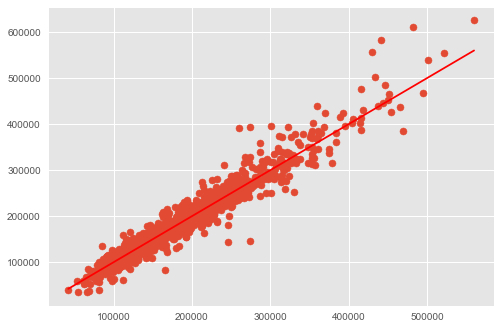

In [44]:
p_pred_0 = np.expm1(model_0.predict(X_train_0))
plt.scatter(p_pred_0, np.expm1(y))
plt.plot([min(p_pred_0),max(p_pred_0)], [min(p_pred_0),max(p_pred_0)], c="red")

# Submit

In [47]:
# save to file to make a submission
train,test= DataStream.load_data("data.json")
p = np.expm1(model_0.predict(X_test_0))
solution = pd.DataFrame({"id":test.Id, "SalePrice":p}, columns=['id', 'SalePrice'])
solution.to_csv("../data/submission/test-3-9-Lasso.csv", index = False)

# A dictonary to store all ranks

In [4]:
ranks={}
names=X_train.columns
def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

# Randomlized Lasso
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RandomizedLasso.html
http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/

In [5]:
rlasso = RandomizedLasso(alpha=2e-4, max_iter=50000,random_state=1,n_resampling=500)
rlasso.fit(X_train, y.values.ravel())

RandomizedLasso(alpha=0.0002, eps=2.2204460492503131e-16, fit_intercept=True,
        max_iter=50000, memory=Memory(cachedir=None), n_jobs=1,
        n_resampling=500, normalize=True, pre_dispatch='3*n_jobs',
        precompute='auto', random_state=1, sample_fraction=0.75,
        scaling=0.5, selection_threshold=0.25, verbose=False)

In [6]:
#print ("Features sorted by their score:")
#rlasso_score = sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), 
#                 names), reverse=True)
ranks["Rand_La"] = rank_to_dict(np.abs(rlasso.scores_), names)

# Recursive elimination

In [7]:
lasso = Lasso(alpha=2e-4, max_iter=50000)
#rank all features, i.e continue the elimination until the last one
rfe = RFE(lasso)
rfe.fit(X_train, y.values.ravel())

RFE(estimator=Lasso(alpha=0.0002, copy_X=True, fit_intercept=True, max_iter=50000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
  n_features_to_select=None, step=1, verbose=0)

In [15]:
#print ("Features sorted by their score:")
#rfe_rank = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), 
#                 names), reverse=True)
#print (rfe_rank)
ranks["Rec_Eli"] = rank_to_dict(np.abs(rfe.ranking_), names,order=-1)

# Report of feature ranks

In [16]:
r = {}
for name in names:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)

ranks["Mean"] = r

ranks_pd = pd.DataFrame(ranks)
ranks_sort=ranks_pd.sort(["Mean","Rand_La","Rec_Eli"],ascending=[False,False,False])
print(ranks_sort)

                   Mean  Rand_La  Rec_Eli
LotArea            0.83     1.00     1.00
SaleCondition_E    0.83     1.00     1.00
MSZoning_E         0.83     0.99     1.00
CentralAir_E       0.82     0.97     1.00
BsmtFinSF1         0.78     0.89     1.00
Functional_E       0.73     0.80     1.00
BsmtExposure_E     0.73     0.79     1.00
OverallScore       0.71     0.75     1.00
totalArea          0.70     0.74     1.00
totalBedRooms      0.68     0.70     1.00
HeatingQC_E        0.67     0.68     1.00
1stFlrSF           0.66     0.66     1.00
MSSubClass_E       0.66     0.66     1.00
GrLivArea          0.64     0.62     1.00
FireplaceScore     0.64     0.61     1.00
YearBuilt          0.63     0.59     1.00
YearRemodAdd       0.63     0.59     1.00
Condition1_E       0.61     0.55     1.00
FlrSF              0.61     0.55     1.00
GarageGrade        0.61     0.55     1.00
BsmtQual_E_S3      0.60     0.54     1.00
GarageFinish_E     0.59     0.52     1.00
PavedDrive_E       0.59     0.51  

## select features without any zero ranks

In [14]:
#######################################################
# please change eps to decide which features are used #
#######################################################
eps = 0.01
top_per = 0.8

#ranks_sort = ranks_sort.apply(pd.to_numeric)
rank_names = ranks_sort.columns
#print(ranks_sort)
#featrue_names = list(ranks_sort.index)
#print(feature_names)
index_zero = []
for rankname in rank_names:
    #index_zero = index_zero + list(
    #    set(list( feature_names[i] for i in np.where(ranks_sort[rankname]<eps)[0] )) 
    #    - set(index_zero)) 
    index_zero = index_zero + list(set(np.where(ranks_sort[rankname]<eps)[0]) - set(index_zero)) 

#print((ranks_sort.iloc[[0]].index)[0])
feature_zero = list( (ranks_sort.iloc[[i]].index)[0] for i in index_zero)
feature_top = list( (ranks_sort.iloc[[i]].index)[0] for i in np.arange(0,ranks_sort.shape[0]*top_per,dtype=int))
#print(feature_zero)

ranks_non_zero = ranks_sort.drop(feature_zero)
feature_non_zero = list(ranks_non_zero.index)

#print(ranks_non_zero)

print ("Features with top mean ranks:")
print(feature_top)
print ("Features with any too low rank:")
print(feature_zero)
print ("Features with all sufficient rank:")
print(feature_non_zero)

Features with top mean ranks:
['ExterScore_Sq', 'Neighborhood_E', 'KitchenAbvGr', 'KitchenQual_E', 'ExterScore_S2', 'ExterScore_S3', 'BsmtCond_E', 'ExterQual_E_Sq', 'ExterQual_E', 'LotArea', 'SaleCondition_E', 'MSZoning_E', 'OverallQual', 'PoolScore', 'CentralAir_E', 'Electrical_E', 'Utilities_E', 'OverallQual_S2', 'Neighborhood_E_S3', 'BsmtFinSF1', 'TotRmsAbvGrd', '3SsnPorch', 'Functional_E', 'BsmtExposure_E', 'GarageArea', 'OverallScore', 'PoolScore_S3', 'BedroomAbvGr', 'Condition2_E', 'totalArea', 'GarageYrBlt', 'totalBedRooms', 'GarageCars_S3', 'HeatingQC_E', 'KitchenQual_E_S2', 'EnclosedPorch', '1stFlrSF', 'MSSubClass_E', 'KitchenQual_E_Sq', 'LandSlope_E', 'BsmtQual_E', 'PoolArea', 'GrLivArea', 'ExterQual_E_S2', 'PoolScore_Sq', 'FireplaceScore', 'YearBuilt', 'YearRemodAdd', 'ExterScore', 'GarageType_E', 'BsmtQual_E_S2', 'TotalBsmtSF', 'Condition1_E', 'FlrSF', 'GarageGrade', 'OpenPorchSF', 'BsmtQual_E_S3', 'BsmtFinType1_E', 'GarageFinish_E', 'PavedDrive_E', 'ScreenPorch', 'GarageCa

# Prediction to submit

In [4]:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

def rmsle(y, y_pred):
     return np.sqrt((( (np.log1p(y_pred*price_scale)- np.log1p(y*price_scale)) )**2).mean())

# scorer = make_scorer(rmsle, False)
scorer = make_scorer(mean_squared_error, False)

def rmse_cv(model, X, y):
     return (cross_val_score(model, X, y, scoring=scorer)).mean()

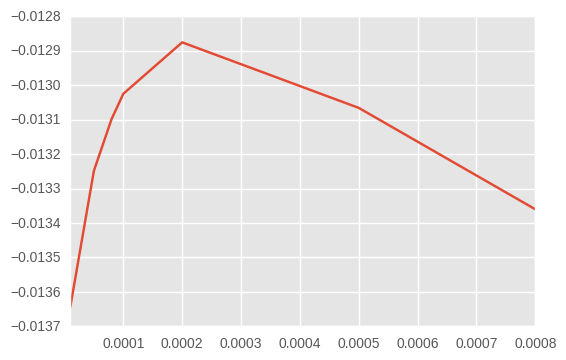

In [5]:
from sklearn.linear_model import Lasso
alphas = [1e-5, 5e-5, 8e-5, 1e-4,2e-4, 5e-4, 8e-4]
cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter=50000), X_train, y) for alpha in alphas]
pd.Series(cv_lasso, index = alphas).plot()

In [6]:
model = Lasso(alpha = 8e-4, max_iter =  50000).fit(X_train, y)

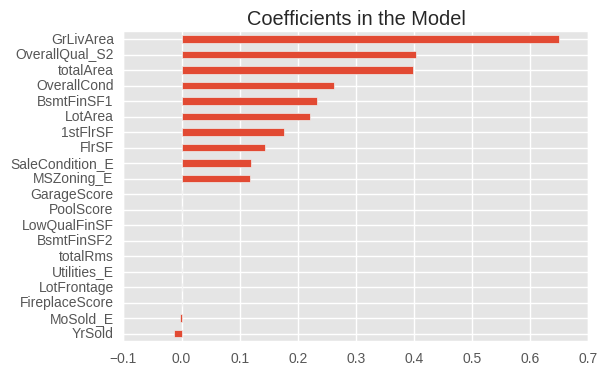

In [7]:
coef = pd.Series(model.coef_, index = X_train.columns).sort_values()
imp_coef = pd.concat([coef.head(10), coef.tail(10)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Model")

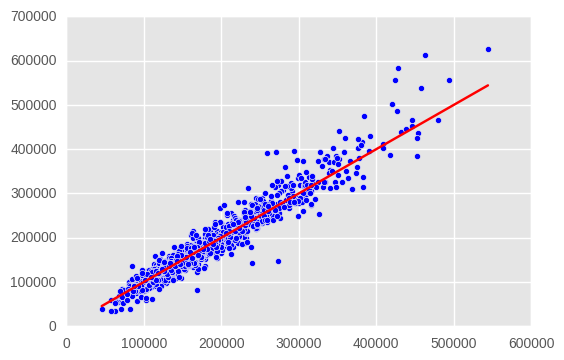

In [8]:
p_pred = np.expm1(model.predict(X_train))
plt.scatter(p_pred, np.expm1(y))
plt.plot([min(p_pred),max(p_pred)], [min(p_pred),max(p_pred)], c="red")